In [29]:
# Importing necessary libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
#for visualization
plt.style.use('ggplot')

## Data Loading and Cleaning
Loading the original tax delinquency data. The first step is to filter out properties that do not have a recorded neighborhood name. The second step is to filter the neighborhoods within the City of Pittsburgh.

In [31]:
#data loading
df = pd.read_csv("ed0d1550-c300-4114-865c-82dc7c23235b.csv")
#first filter
df_pgh = df.dropna(subset=['neighborhood']).copy()
#second filter
df_pgh = df_pgh[df_pgh['billing_city'] == 'PITTSBURGH, PA'].copy()

print(f"Total original records loaded: {len(df)}")
print(f"Records after filters (Pittsburgh city and valid neighborhood): {len(df_pgh)}")

Total original records loaded: 26413
Records after filters (Pittsburgh city and valid neighborhood): 18489


## Identifying Delinquent Properties

In [32]:
# Creating a boolean flag for delinquency
delinquent_flag = (df_pgh['current_delq_tax'] > 0) | \
                  (df_pgh['current_delq_pi'] > 0) | \
                  (df_pgh['prior_delq_tax'] > 0) | \
                  (df_pgh['prior_delq_pi'] > 0)

# (1 = Delinquent, 0 = Clean) column
df_pgh['is_delinquent'] = delinquent_flag.astype(int)

# 3. Calculate the total delinquent amount using multiple column
df_pgh['total_delinquent_amount'] = (
    df_pgh['current_delq_tax'] + 
    df_pgh['current_delq_pi'] + 
    df_pgh['prior_delq_tax'] + 
    df_pgh['prior_delq_pi']
)

print(f"Total number of properties marked as delinquent: {df_pgh['is_delinquent'].sum()}")

Total number of properties marked as delinquent: 18489


## Calculating and Rescalling the Three Sub-Metrics (S1, S2, S3)

In [50]:
def minmax_normalize(series, lower_is_better=False):
    min_val = series.min()
    max_val = series.max()
#  if (max - min) is zero normalize
    if np.isclose(min_val, max_val):
    # If the range is zero, the normalized value is 1.0 (equally stable)
        normalized = 1.0
    else:
        normalized = (series - min_val) / (max_val - min_val)
    if lower_is_better:
        return 1 - normalized
    else:
        return normalized

## Aggregat Values per Neighborhood

In [43]:
neighborhood_agg = df_pgh.groupby('neighborhood').agg(
    total_properties=('pin', 'count'),
    delinquent_count=('is_delinquent', 'sum'),
    total_delinquent_amount=('total_delinquent_amount', 'sum'),
    residential_count=('state_description', lambda x: (x == 'Residential').sum())
).reset_index()

## S1

In [44]:
neighborhood_agg['delinquency_rate'] = (
    neighborhood_agg['delinquent_count'] / neighborhood_agg['total_properties']
)

neighborhood_agg['S1_Frequency_Score'] = minmax_normalize(
    neighborhood_agg['delinquency_rate'], lower_is_better=True
)

## S2

In [45]:
neighborhood_agg['S2_Severity_Score'] = minmax_normalize(
    neighborhood_agg['total_delinquent_amount'], lower_is_better=True
)

## S3

In [46]:
neighborhood_agg['residential_percent'] = (
    neighborhood_agg['residential_count'] / neighborhood_agg['total_properties']
)

neighborhood_agg['S3_Type_Score'] = minmax_normalize(
    neighborhood_agg['residential_percent'], lower_is_better=False
)

## Weighted Index (Final)

In [48]:
# weights: 0.40, 0.30, 0.30
neighborhood_agg['Property_Stability_Index'] = (
    0.40 * neighborhood_agg['S1_Frequency_Score'] +
    0.30 * neighborhood_agg['S2_Severity_Score'] +
    0.30 * neighborhood_agg['S3_Type_Score']
)


## Final Stability Score

In [51]:
fiscal_stability_scores = neighborhood_agg[['neighborhood', 'Property_Stability_Index']].copy()

print("--- Top 10 Neighborhoods by Property Risk & Stability Index ---")
print(fiscal_stability_scores.sort_values(
    by='Property_Stability_Index', ascending=False
).head(10))

--- Top 10 Neighborhoods by Property Risk & Stability Index ---
         neighborhood  Property_Stability_Index
35         Glen Hazel                  0.599994
4   Arlington Heights                  0.598824
66      Regent Square                  0.597410
58  Northview Heights                  0.596967
55      New Homestead                  0.591260
81        Summer Hill                  0.591142
11            Bon Air                  0.586855
67          Ridgemont                  0.586200
20     Chartiers City                  0.583871
37               Hays                  0.578926


## Visualization

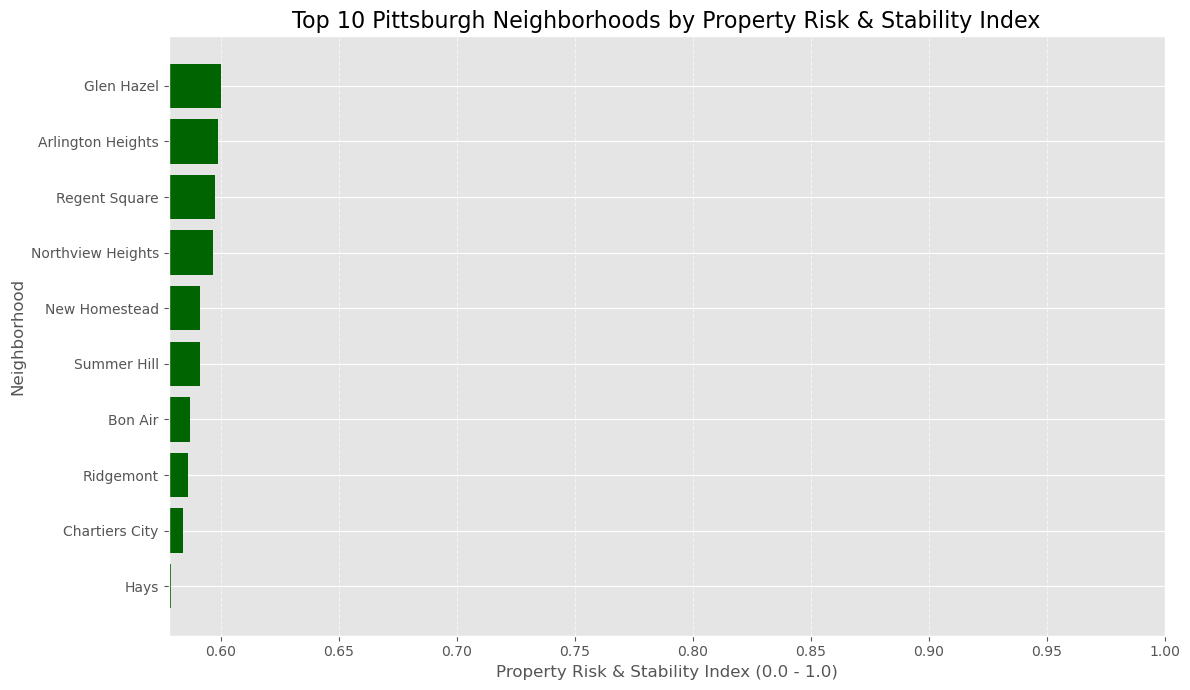

In [52]:
plt.style.use('ggplot') 

top_10 = fiscal_stability_scores.sort_values(
    by='Property_Stability_Index', ascending=False
).head(10).sort_values(by='Property_Stability_Index', ascending=True)

plt.figure(figsize=(12, 7))
plt.barh(top_10['neighborhood'], top_10['Property_Stability_Index'], color='darkgreen')
plt.title('Top 10 Pittsburgh Neighborhoods by Property Risk & Stability Index', fontsize=16)
plt.xlabel('Property Risk & Stability Index (0.0 - 1.0)', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.xlim(top_10['Property_Stability_Index'].min() - 0.001, 1.0) 
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()